In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

## PDE 
The acoustic wave equation for the square slowness m and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

In [3]:
p=Function('p')
m,s,h = symbols('m s h')
m=M(x,y,z)
q=Q(x,y,z,t)
d=D(x,y,z,t)
e=E(x,y,z)

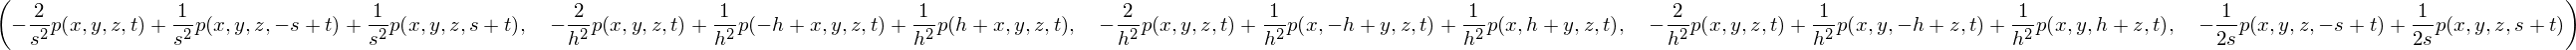

In [5]:
dtt=as_finite_diff(p(x,y,z,t).diff(t,t), [t-s,t, t+s])
dt=as_finite_diff(p(x,y,z,t).diff(t), [t-s, t+s])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxx=as_finite_diff(p(x,y,z,t).diff(x,x), [x-h, x, x+h]) 
dyy=as_finite_diff(p(x,y,z,t).diff(y,y), [y-h, y, y+h])
dzz=as_finite_diff(p(x,y,z,t).diff(z,z), [z-h, z, z+h])
dtt,dxx,dyy,dzz,dt

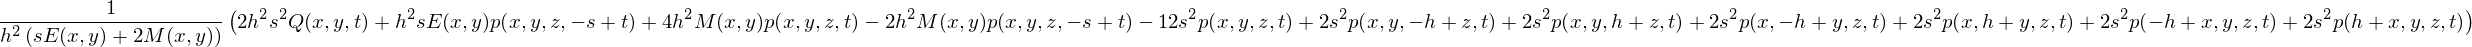

In [9]:
# Forward wave equation
wave_equation = m*dtt- (dxx+dyy+dzz) - q  + e*dt
stencil = solve(wave_equation,p(x,y,z,t+s))[0]
ts=lambdify((p(x,y,z,t-s),p(x-h,y,z,t), p(x+h,y,z,t), p(x,y-h,z,t),p(x,y+h,z,t), p(x,y,z-h,t), p(x,y,z+h,t), q , m, s, h,e),stencil,"numpy")
stencil

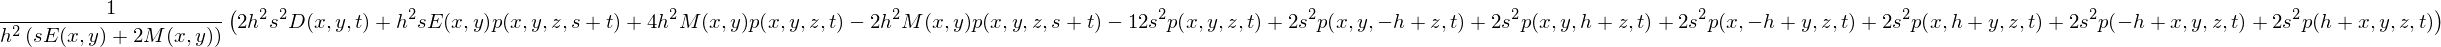

In [10]:
# Adjoint wave equation
wave_equationA = m*dtt- (dxx+dyy+dzz) - D(x,y,t) - e*dt
stencilA = solve(wave_equationA,p(x,y,z,t-s))[0]
tsA=lambdify((p(x,y,z,t+s),p(x-h,y,z,t), p(x+h,y,z,t), p(x,y-h,z,t),p(x,y+h,z,t), p(x,y,z-h,t), p(x,y,z+h,t), d , m, s, h,e),stencilA,"numpy")
stencilA